In [1]:
import os

import matplotlib
import numpy as np
import requests

from genericdlmodel import Model

%matplotlib widget

In [2]:
#headers = {
#    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:10.0) Gecko/20100101 Firefox/10.0"
#}
request_opts = {"params": {"raw": "true"}}

In [3]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

base_url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/"
fname = "mnist.npz"
fpath = os.path.join(data_dir, fname)
if not os.path.exists(fpath):
    print("Downloading file: " + fname)
    resp = requests.get(base_url + fname, stream=True, **request_opts)
    resp.raise_for_status()
    with open(fpath, "wb") as fh:
        for chunk in resp.iter_content(chunk_size=128):
            fh.write(chunk)

In [4]:
data_file = np.load(fpath)
x_train = data_file["x_train"]
x_test = data_file["x_test"]
y_train = data_file["y_train"]
y_test = data_file["y_test"]
data_file.close()

In [5]:
x_train = x_train.reshape(len(x_train), 28 * 28)
x_test = x_test.reshape(len(x_test), 28 * 28)

In [6]:
sample_size = int(len(x_train))
test_split = 5 * sample_size // 6
seed = 1234
rng = np.random.default_rng(seed=seed)
index = rng.choice(len(x_train), sample_size)
train_sample_X = x_train[index[:test_split]]
val_sample_X = x_train[index[test_split:]]
train_sample_y = y_train[index[:test_split]]
val_sample_y = y_train[index[test_split:]]

In [7]:
train_sample_X = train_sample_X * 1.0 / 255
val_sample_X = val_sample_X * 1.0 / 255
test_sample_X = x_test * 1.0 / 255

In [8]:
def one_hot_encoding(labels, dim=10):
    one_hot_labels = labels[..., None] == np.arange(dim)[None]
    return one_hot_labels.astype(np.float64)

In [9]:
train_sample_labels = one_hot_encoding(train_sample_y)
val_sample_labels = one_hot_encoding(val_sample_y)
test_sample_labels = one_hot_encoding(y_test)

In [10]:
learning_rate = 0.1
epochs = 20
pixels_per_image = 28 * 28
num_labels = 10
batch_size = 100
dropout = 0.45
hidden_layer_sizes = [200, 50]
update_rule = "identity"
update_args = {}

In [11]:
model = Model(
    rng=rng,
    training_data_X=train_sample_X,
    training_data_y=train_sample_labels,
    val_data_X=val_sample_X,
    val_data_y=val_sample_labels,
    objective_function="categoricalcrossentropy",
    learning_rate=learning_rate,
    epochs=epochs,
    batch_size=batch_size,
)

In [12]:
for output_size in hidden_layer_sizes:
    model.add_layer(
        output_size=output_size,
        func_name="relu",
        dropout=dropout,
        update_rule=update_rule,
        update_args=update_args,
    )
model.add_final_layer()

In [13]:
%%time
model.run()

Epoch: 0
  Training loss:          19.185
  Training accuracy:      0.439
  Validation loss:        19.418
  Validation accuracy:    0.589

Epoch: 1
  Training loss:          18.866
  Training accuracy:      0.640
  Validation loss:        19.513
  Validation accuracy:    0.694

Epoch: 2
  Training loss:          19.544
  Training accuracy:      0.718
  Validation loss:        19.814
  Validation accuracy:    0.740

Epoch: 3
  Training loss:          20.072
  Training accuracy:      0.757
  Validation loss:        20.089
  Validation accuracy:    0.769

Epoch: 4
  Training loss:          20.398
  Training accuracy:      0.787
  Validation loss:        20.425
  Validation accuracy:    0.801

Epoch: 5
  Training loss:          20.677
  Training accuracy:      0.807
  Validation loss:        20.631
  Validation accuracy:    0.816

Epoch: 6
  Training loss:          20.925
  Training accuracy:      0.823
  Validation loss:        21.064
  Validation accuracy:    0.828

Epoch: 7
  Training 

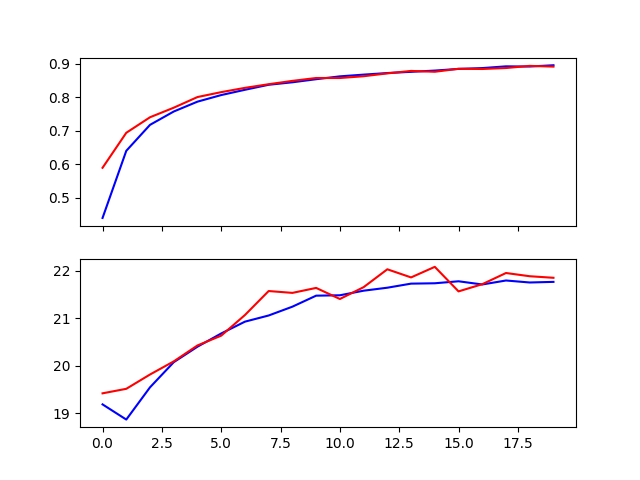

In [14]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots

fig, axs = subplots(2, sharex="col")
x = np.arange(epochs)
y1 = model.training_acc
y2 = model.training_loss
y3 = model.val_acc
y4 = model.val_loss
axs[0].plot(x, y1, "b-")
axs[1].plot(x, y2, "b-")
axs[0].plot(x, y3, "r-")
axs[1].plot(x, y4, "r-")

In [15]:
learning_rate = 0.1
epochs = 20
pixels_per_image = 28 * 28
num_labels = 10
batch_size = 100
dropout = 0
hidden_layer_sizes = [200, 50]
update_rule = "SVD"
update_args = {'rank':3}

In [16]:
model2 = Model(
    rng=rng,
    training_data_X=train_sample_X,
    training_data_y=train_sample_labels,
    val_data_X=val_sample_X,
    val_data_y=val_sample_labels,
    objective_function="categoricalcrossentropy",
    learning_rate=learning_rate,
    epochs=epochs,
    batch_size=batch_size,
)

In [17]:
for output_size in hidden_layer_sizes:
    model2.add_layer(
        output_size=output_size,
        func_name="relu",
        dropout=dropout,
        update_rule=update_rule,
        update_args=update_args,
    )
model2.add_final_layer(update_rule=update_rule, update_args=update_args)

In [18]:
%%time
model2.run()

Epoch: 0
  Training loss:          15.738
  Training accuracy:      0.743
  Validation loss:        13.768
  Validation accuracy:    0.855

Epoch: 1
  Training loss:          14.834
  Training accuracy:      0.871
  Validation loss:        14.039
  Validation accuracy:    0.886

Epoch: 2
  Training loss:          15.229
  Training accuracy:      0.894
  Validation loss:        14.329
  Validation accuracy:    0.902

Epoch: 3
  Training loss:          15.599
  Training accuracy:      0.908
  Validation loss:        14.538
  Validation accuracy:    0.910

Epoch: 4
  Training loss:          15.945
  Training accuracy:      0.917
  Validation loss:        14.884
  Validation accuracy:    0.916

Epoch: 5
  Training loss:          16.236
  Training accuracy:      0.923
  Validation loss:        15.213
  Validation accuracy:    0.920

Epoch: 6
  Training loss:          16.499
  Training accuracy:      0.929
  Validation loss:        15.441
  Validation accuracy:    0.926

Epoch: 7
  Training 

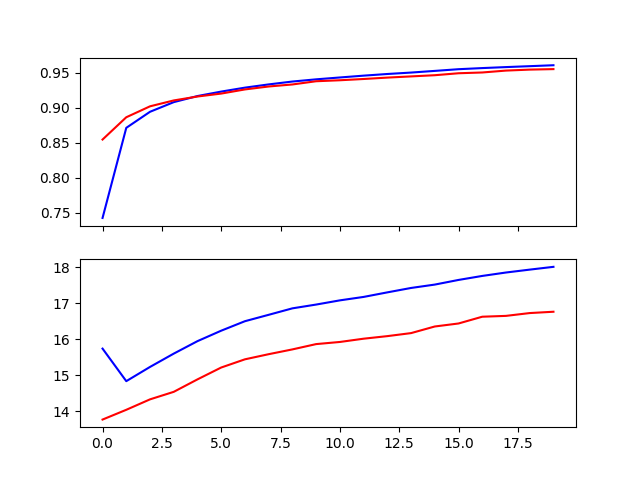

In [19]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots

fig, axs = subplots(2, sharex="col")
x = np.arange(epochs)
y1 = model2.training_acc
y2 = model2.training_loss
y3 = model2.val_acc
y4 = model2.val_loss
axs[0].plot(x, y1, "b-")
axs[1].plot(x, y2, "b-")
axs[0].plot(x, y3, "r-")
axs[1].plot(x, y4, "r-")

In [34]:
learning_rate = 0.1
epochs = 20
pixels_per_image = 28 * 28
num_labels = 10
batch_size = 10 # smaller batch sizes for rank one updates??
                # batch size 50 gives accuracy .85 after 20 epochs
dropout = 0
hidden_layer_sizes = [200, 50]
update_rule = "rank one update"
update_args = {"rng":rng, "num_iter" : 20}

In [35]:
model3 = Model(
    rng=rng,
    training_data_X=train_sample_X,
    training_data_y=train_sample_labels,
    val_data_X=val_sample_X,
    val_data_y=val_sample_labels,
    objective_function="categoricalcrossentropy",
    learning_rate=learning_rate,
    epochs=epochs,
    batch_size=batch_size,
)

In [36]:
for output_size in hidden_layer_sizes:
    model3.add_layer(
        output_size=output_size,
        func_name="relu",
        dropout=dropout,
        update_rule=update_rule,
        update_args=update_args,
    )
model3.add_final_layer(update_rule=update_rule, update_args=update_args)

In [37]:
%%time
model3.run()

Epoch: 0
  Training loss:          16.529
  Training accuracy:      0.755
  Validation loss:        14.369
  Validation accuracy:    0.849

Epoch: 1
  Training loss:          15.434
  Training accuracy:      0.871
  Validation loss:        14.048
  Validation accuracy:    0.888

Epoch: 2
  Training loss:          15.541
  Training accuracy:      0.900
  Validation loss:        14.094
  Validation accuracy:    0.907

Epoch: 3
  Training loss:          15.876
  Training accuracy:      0.915
  Validation loss:        14.542
  Validation accuracy:    0.917

Epoch: 4
  Training loss:          16.231
  Training accuracy:      0.925
  Validation loss:        14.855
  Validation accuracy:    0.928

Epoch: 5
  Training loss:          16.498
  Training accuracy:      0.934
  Validation loss:        15.193
  Validation accuracy:    0.934

Epoch: 6
  Training loss:          16.639
  Training accuracy:      0.942
  Validation loss:        15.403
  Validation accuracy:    0.940

Epoch: 7
  Training 

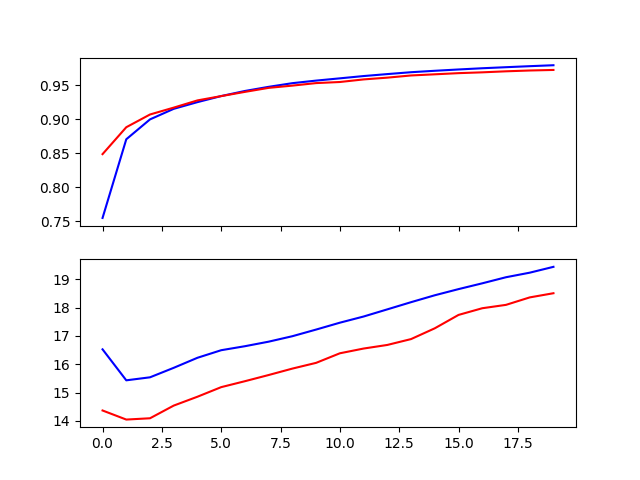

In [38]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots

fig, axs = subplots(2, sharex="col")
x = np.arange(epochs)
y1 = model3.training_acc
y2 = model3.training_loss
y3 = model3.val_acc
y4 = model3.val_loss
axs[0].plot(x, y1, "b-")
axs[1].plot(x, y2, "b-")
axs[0].plot(x, y3, "r-")
axs[1].plot(x, y4, "r-")

More tests
----------
1. Larger/smaller batch size
2. Simulation of GPU
3. different choices for rank in SVD